## Setup

In [1]:
import os
os.chdir("..")

import pandas as pd
import numpy as np
from scripts.preprocessing import PreProcessor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, roc_curve
sns.set_theme()

In [2]:
from scripts.utils import variables as var

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Process Raw Data

In [4]:
preprocessor = PreProcessor()
Xs, ys = preprocessor.run_processes(resample=False, scale=True, reduce=True)

X_test, X_train, X_val = Xs
y_test, y_train, y_val = ys

Train: 7556 | 0.22789835892006352
Val: 1890 | 0.22804232804232805
Test: 2362 | 0.2277730736663844


## Hyperparameter Tuning

In [29]:
param_grid = {
    'max_depth': [3, 5, 10],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 1.0],  # Step size shrinkage
    'n_estimators': [10, 100],  # Number of boosting rounds
}

In [30]:
model = xgb.XGBClassifier(objective = 'binary:logistic', random_state=preprocessor.seed)

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring='roc_auc',
    cv=3,
    )

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'max_depth': [3, 5, 10], 'n_estimators': [10, 100]},
             scoring='roc_auc')

## Best Parameters and Scores

In [31]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6780681376706497
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


## Validation

In [32]:
best_model = xgb.XGBClassifier(
    objective = 'binary:logistic', 
    random_state=preprocessor.seed,
    max_depth = grid_search.best_params_['max_depth'],
    learning_rate = grid_search.best_params_['learning_rate'],
    n_estimators = grid_search.best_params_['n_estimators'],
    eval_metric='auc'
    
    )
best_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)])

[0]	validation_0-auc:0.65934	validation_1-auc:0.67043
[1]	validation_0-auc:0.67130	validation_1-auc:0.68755
[2]	validation_0-auc:0.67275	validation_1-auc:0.68767
[3]	validation_0-auc:0.67641	validation_1-auc:0.69588
[4]	validation_0-auc:0.67880	validation_1-auc:0.69632
[5]	validation_0-auc:0.67989	validation_1-auc:0.69556
[6]	validation_0-auc:0.68091	validation_1-auc:0.69727
[7]	validation_0-auc:0.68368	validation_1-auc:0.69832
[8]	validation_0-auc:0.68734	validation_1-auc:0.70031
[9]	validation_0-auc:0.69000	validation_1-auc:0.70033
[10]	validation_0-auc:0.68984	validation_1-auc:0.70048
[11]	validation_0-auc:0.69181	validation_1-auc:0.70229
[12]	validation_0-auc:0.69326	validation_1-auc:0.70305
[13]	validation_0-auc:0.69605	validation_1-auc:0.70374
[14]	validation_0-auc:0.69744	validation_1-auc:0.70396
[15]	validation_0-auc:0.69937	validation_1-auc:0.70552
[16]	validation_0-auc:0.70054	validation_1-auc:0.70573
[17]	validation_0-auc:0.70133	validation_1-auc:0.70564
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
train_auc = best_model.evals_result()['validation_0']['auc']
val_auc = best_model.evals_result()['validation_1']['auc']
iterations = range(0, len(val_auc))

### Learning Curves

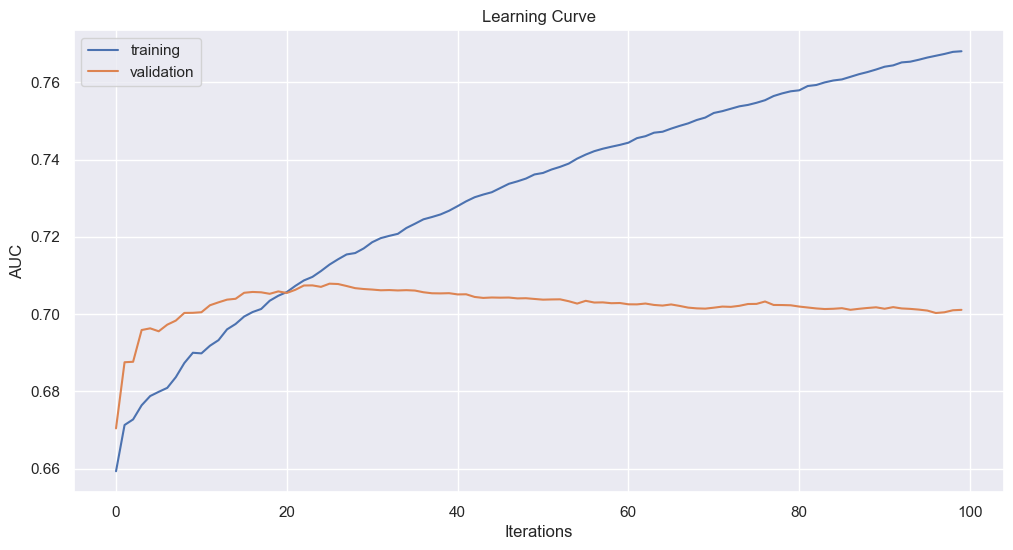

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(iterations, train_auc, label='training')
ax.plot(iterations, val_auc, label='validation')
ax.set_title('Learning Curve')
ax.set_xlabel('Iterations')
ax.set_ylabel('AUC')
ax.legend()

### ROC Curves

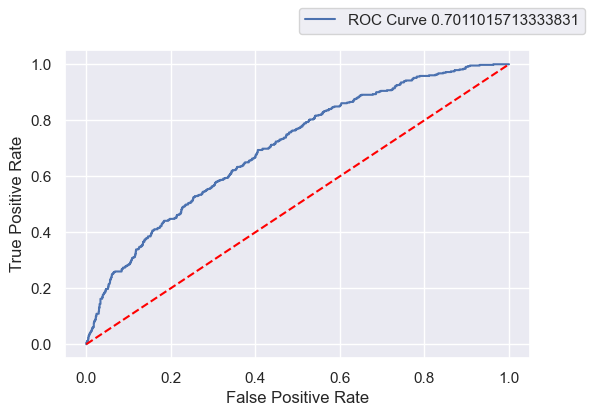

In [35]:
y_val_preds_proba = best_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_preds_proba)
auc = roc_auc_score(y_val, y_val_preds_proba)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fpr, tpr, label=f'ROC Curve {auc}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1],[0,1], color='red', linestyle='--')
fig.legend()

### PR Curve

In [36]:
precision_val, recall_val, t_val = precision_recall_curve(y_val, y_val_preds_proba)

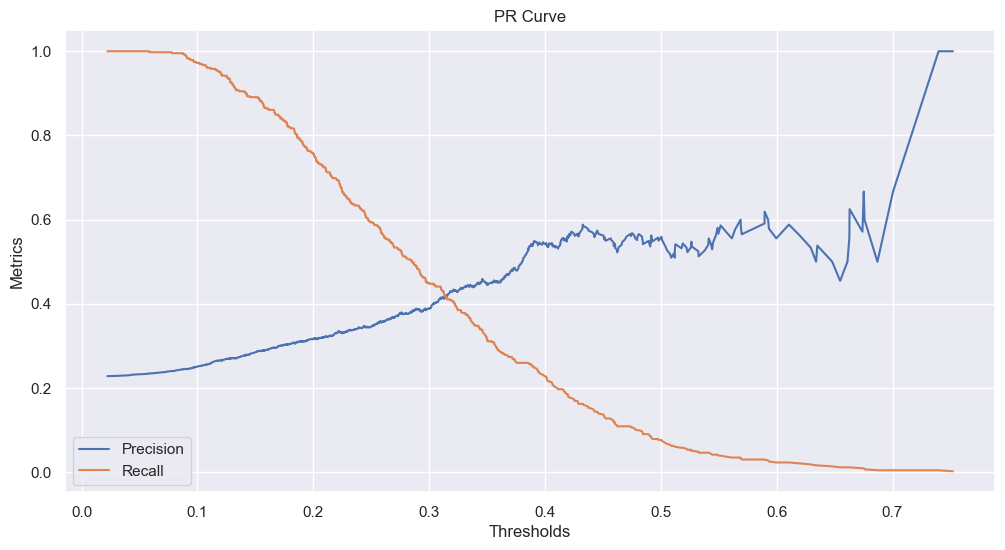

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t_val, precision_val[:-1], label='Precision')
ax.plot(t_val, recall_val[:-1], label='Recall')
ax.set_title('PR Curve')
ax.set_xlabel('Thresholds')
ax.set_ylabel('Metrics')
ax.legend()

In [43]:
diff = precision_val[:-1] - recall_val[:-1]
crossing_index = np.where(np.diff(np.sign(diff)))[0]

# Use the crossing index to find the corresponding threshold
optimal_t = np.mean(t_val[crossing_index])


In [38]:
optimal_t = 0.32

In [39]:
y_test_preds_proba = best_model.predict_proba(X_test)[:,1]
y_test_preds = (y_test_preds_proba>optimal_t).astype(int)

precision_test = precision_score(y_test, y_test_preds)
recall_test = recall_score(y_test, y_test_preds)

print(f"Precision {precision_test} | Recall {recall_test}")

roc_auc_score(y_test, y_test_preds)

Precision 0.43434343434343436 | Recall 0.3996282527881041


0.6230597404291397

## Test Framework

In [132]:
from scripts.framework import ModelFramework


Train: 7556 | 0.22789835892006352
Val: 1890 | 0.22804232804232805
Test: 2362 | 0.2277730736663844
[0]	validation_0-auc:0.67532	validation_1-auc:0.66546
[1]	validation_0-auc:0.69525	validation_1-auc:0.67782
[2]	validation_0-auc:0.70347	validation_1-auc:0.68756
[3]	validation_0-auc:0.71135	validation_1-auc:0.69273
[4]	validation_0-auc:0.71669	validation_1-auc:0.69886
[5]	validation_0-auc:0.71928	validation_1-auc:0.70191
[6]	validation_0-auc:0.72109	validation_1-auc:0.70077
[7]	validation_0-auc:0.72174	validation_1-auc:0.70134
[8]	validation_0-auc:0.72277	validation_1-auc:0.70057
[9]	validation_0-auc:0.72362	validation_1-auc:0.70022
[10]	validation_0-auc:0.72607	validation_1-auc:0.70245
[11]	validation_0-auc:0.72881	validation_1-auc:0.70421
[12]	validation_0-auc:0.73065	validation_1-auc:0.70705
[13]	validation_0-auc:0.73195	validation_1-auc:0.70608
[14]	validation_0-auc:0.73398	validation_1-auc:0.70747
[15]	validation_0-auc:0.73671	validation_1-auc:0.70926
[16]	validation_0-auc:0.73746	va

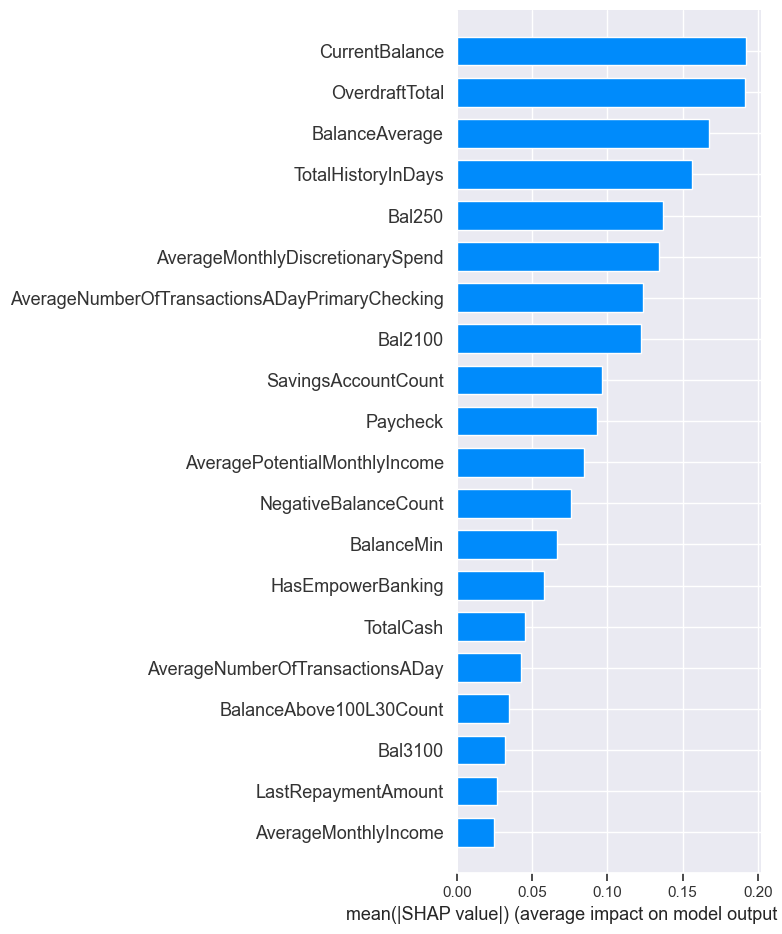

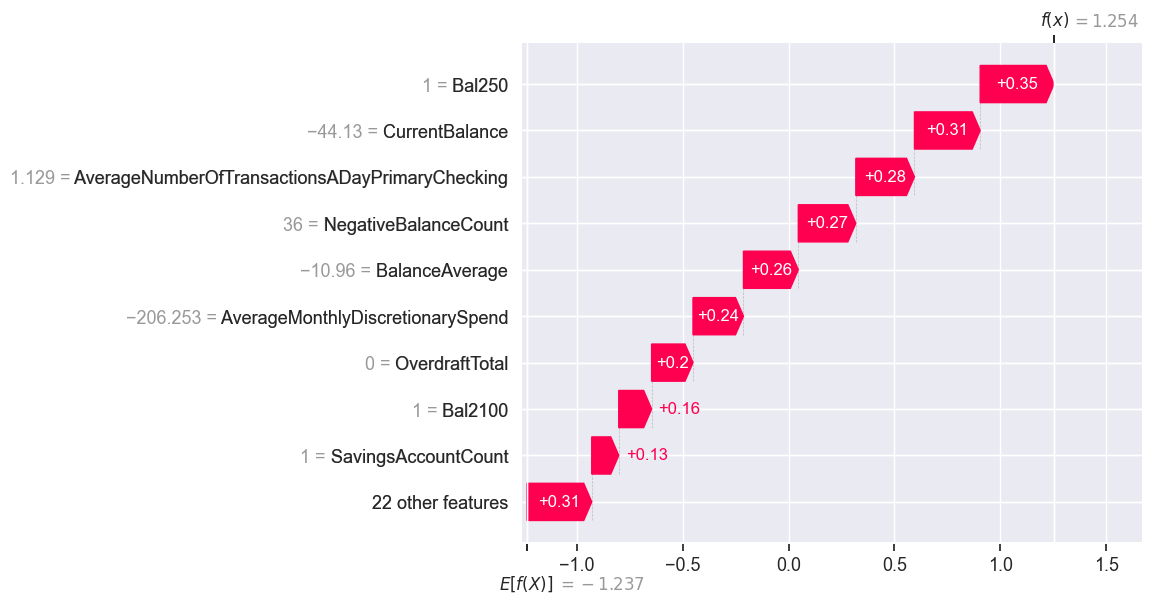

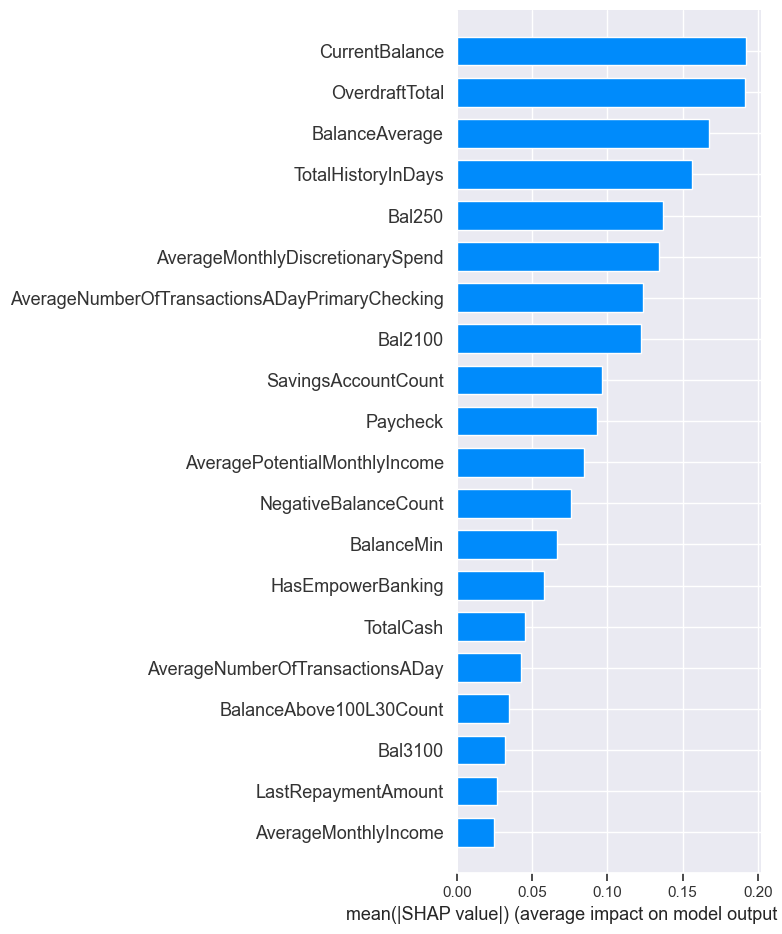

In [136]:
Xs, ys, best_model, optimal_t, val_auc, test_auc = ModelFramework(explain=True).run()